In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from itertools import chain
import scipy
import skimage
from PIL import Image
sns.set()
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator



##Import any other packages you may need here

Using TensorFlow backend.


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2446,00012283_000.png,Infiltration|Mass,0,12283,019Y,F,PA,2654,2991,0.143,0.143
3022,00014860_000.png,No Finding,0,14860,081Y,F,PA,2514,2717,0.143,0.143
5139,00027355_005.png,Edema,5,27355,015Y,M,AP,3056,2544,0.139,0.139


In [3]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [4]:
all_xray_df.shape

(112120, 12)

In [5]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [6]:
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


We can see that maximum age is 414

In [7]:
all_xray_df[all_xray_df['Patient Age'] > 100]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139,NaN
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,NaN
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143,NaN
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143,NaN
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143,NaN
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143,NaN
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143,NaN
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143,NaN
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139,NaN
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139,NaN


In [8]:
#Here we will replace age which is over 100 to mean value of 46
average_age = int(all_xray_df[all_xray_df['Patient Age'] < 100]['Patient Age'].mean())
for idx in range(all_xray_df.shape[0]):
    if all_xray_df.iloc[idx, 4] > 100:
        print(f'{all_xray_df.iloc[idx, 0]} : age {all_xray_df.iloc[idx, 4]} is changed to ->> {average_age}')
        all_xray_df.iloc[idx, 4] = average_age

all_xray_df[all_xray_df['Patient Age'] > 100]

00005567_000.png : age 412 is changed to ->> 46
00011973_002.png : age 414 is changed to ->> 46
00012238_010.png : age 148 is changed to ->> 46
00013950_000.png : age 148 is changed to ->> 46
00014520_026.png : age 150 is changed to ->> 46
00015558_000.png : age 149 is changed to ->> 46
00018366_044.png : age 152 is changed to ->> 46
00019346_000.png : age 151 is changed to ->> 46
00020900_002.png : age 411 is changed to ->> 46
00021047_002.png : age 412 is changed to ->> 46
00021275_003.png : age 413 is changed to ->> 46
00022811_000.png : age 412 is changed to ->> 46
00025206_000.png : age 153 is changed to ->> 46
00026028_001.png : age 154 is changed to ->> 46
00026871_000.png : age 155 is changed to ->> 46
00027989_000.png : age 155 is changed to ->> 46


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11


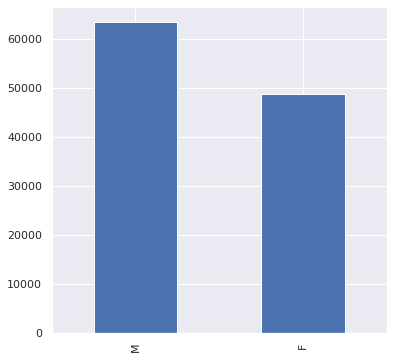

In [9]:
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')

(array([  99.,  189.,  340.,  393.,  782.,  700.,  909., 1224.,  605.,
        1583., 2178., 2548., 2609., 2538., 2925., 3250., 1688., 3452.,
        3131., 3059., 3753., 3510., 4251., 4896., 2270., 4800., 4946.,
        5469., 5579., 5687., 5725., 4623., 4318., 2037., 4087., 2985.,
        2236., 1864., 1564., 1144.,  793.,  262.,  476.,  269.,  117.,
         139.,   53.,   41.,   15.,    9.]),
 array([ 1.  ,  2.88,  4.76,  6.64,  8.52, 10.4 , 12.28, 14.16, 16.04,
        17.92, 19.8 , 21.68, 23.56, 25.44, 27.32, 29.2 , 31.08, 32.96,
        34.84, 36.72, 38.6 , 40.48, 42.36, 44.24, 46.12, 48.  , 49.88,
        51.76, 53.64, 55.52, 57.4 , 59.28, 61.16, 63.04, 64.92, 66.8 ,
        68.68, 70.56, 72.44, 74.32, 76.2 , 78.08, 79.96, 81.84, 83.72,
        85.6 , 87.48, 89.36, 91.24, 93.12, 95.  ]),
 <a list of 50 Patch objects>)

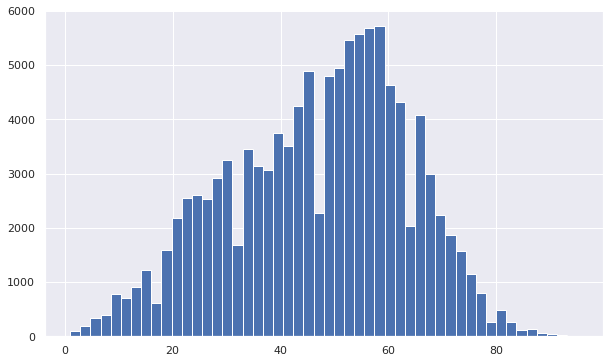

In [10]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'], bins =50)

In [11]:
male_age = all_xray_df.loc[(all_xray_df["Patient Gender"] == 'M'), "Patient Age"].tolist()
female_age = all_xray_df.loc[(all_xray_df["Patient Gender"] == 'F'), "Patient Age"].tolist()

(array([  56.,   99.,  201.,  210.,  490.,  289.,  533.,  335.,  795.,
         939., 1347., 1595., 1502., 1376.,  992., 1621., 1727., 2038.,
        1582., 1571., 1948.,  869., 2086., 2382., 2583., 2432., 2619.,
        3063., 1601., 3129., 3591., 2890., 2566., 2676., 2486.,  957.,
        1468., 1357., 1052.,  690.,  620.,  365.,  120.,  189.,  101.,
          78.,   67.,   30.,   12.,   15.]),
 array([ 1.  ,  2.86,  4.72,  6.58,  8.44, 10.3 , 12.16, 14.02, 15.88,
        17.74, 19.6 , 21.46, 23.32, 25.18, 27.04, 28.9 , 30.76, 32.62,
        34.48, 36.34, 38.2 , 40.06, 41.92, 43.78, 45.64, 47.5 , 49.36,
        51.22, 53.08, 54.94, 56.8 , 58.66, 60.52, 62.38, 64.24, 66.1 ,
        67.96, 69.82, 71.68, 73.54, 75.4 , 77.26, 79.12, 80.98, 82.84,
        84.7 , 86.56, 88.42, 90.28, 92.14, 94.  ]),
 <a list of 50 Patch objects>)

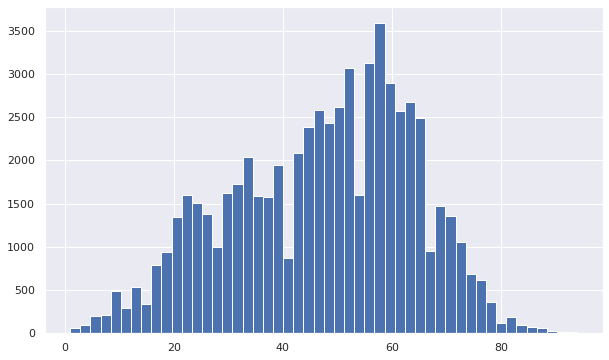

In [12]:
plt.figure(figsize=(10,6))
plt.hist(male_age, bins=50)

(array([4.300e+01, 9.000e+01, 1.390e+02, 1.830e+02, 2.920e+02, 4.110e+02,
        3.760e+02, 4.260e+02, 2.730e+02, 6.440e+02, 8.310e+02, 9.530e+02,
        1.107e+03, 1.162e+03, 1.168e+03, 1.524e+03, 8.310e+02, 1.414e+03,
        1.549e+03, 1.488e+03, 1.805e+03, 1.580e+03, 2.135e+03, 2.169e+03,
        1.123e+03, 2.368e+03, 2.327e+03, 2.406e+03, 2.415e+03, 2.461e+03,
        2.331e+03, 1.910e+03, 1.680e+03, 7.190e+02, 1.601e+03, 1.306e+03,
        7.840e+02, 7.630e+02, 5.990e+02, 4.770e+02, 3.120e+02, 9.800e+01,
        2.370e+02, 1.290e+02, 5.500e+01, 3.700e+01, 1.600e+01, 2.900e+01,
        3.000e+00, 1.000e+00]),
 array([ 1.  ,  2.88,  4.76,  6.64,  8.52, 10.4 , 12.28, 14.16, 16.04,
        17.92, 19.8 , 21.68, 23.56, 25.44, 27.32, 29.2 , 31.08, 32.96,
        34.84, 36.72, 38.6 , 40.48, 42.36, 44.24, 46.12, 48.  , 49.88,
        51.76, 53.64, 55.52, 57.4 , 59.28, 61.16, 63.04, 64.92, 66.8 ,
        68.68, 70.56, 72.44, 74.32, 76.2 , 78.08, 79.96, 81.84, 83.72,
        85.6 , 87.48,

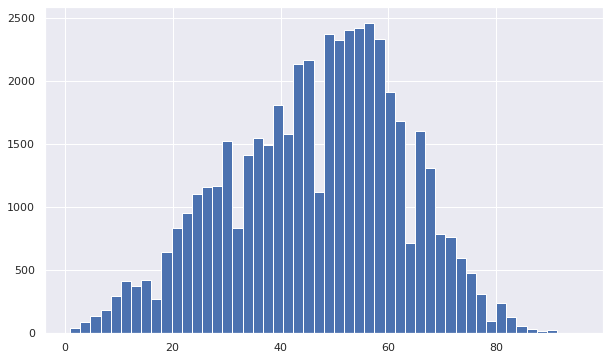

In [13]:
plt.figure(figsize=(10,6))
plt.hist(female_age, bins=50)

(array([6.0385e+04, 1.8040e+04, 7.7020e+03, 6.5600e+03, 4.3490e+03,
        2.4150e+03, 2.4870e+03, 1.8670e+03, 1.1350e+03, 1.2270e+03,
        1.0060e+03, 6.2900e+02, 7.3300e+02, 6.1400e+02, 3.8200e+02,
        4.1500e+02, 3.4800e+02, 2.1300e+02, 2.2500e+02, 1.8000e+02,
        1.2200e+02, 1.4400e+02, 1.2000e+02, 7.7000e+01, 8.4000e+01,
        7.6000e+01, 5.7000e+01, 7.1000e+01, 6.8000e+01, 4.4000e+01,
        4.9000e+01, 3.9000e+01, 2.2000e+01, 2.8000e+01, 2.8000e+01,
        1.9000e+01, 2.4000e+01, 2.1000e+01, 1.5000e+01, 1.6000e+01,
        1.6000e+01, 1.2000e+01, 1.5000e+01, 8.0000e+00, 6.0000e+00,
        8.0000e+00, 8.0000e+00, 3.0000e+00, 4.0000e+00, 4.0000e+00]),
 array([  0.  ,   3.66,   7.32,  10.98,  14.64,  18.3 ,  21.96,  25.62,
         29.28,  32.94,  36.6 ,  40.26,  43.92,  47.58,  51.24,  54.9 ,
         58.56,  62.22,  65.88,  69.54,  73.2 ,  76.86,  80.52,  84.18,
         87.84,  91.5 ,  95.16,  98.82, 102.48, 106.14, 109.8 , 113.46,
        117.12, 120.78, 124.44

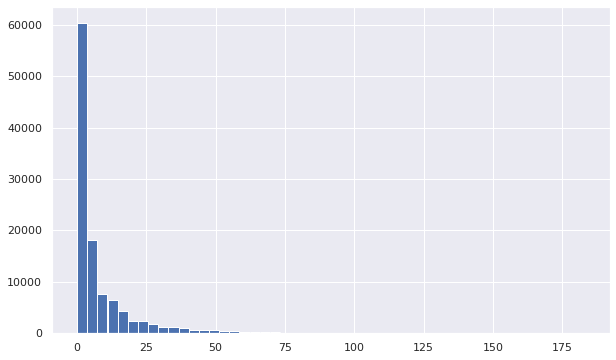

In [14]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Follow-up #'], bins=50)

(array([67310.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 44810.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

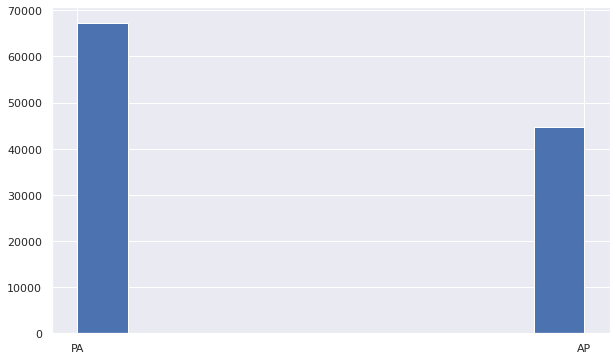

In [15]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['View Position'])

In [16]:
all_xray_df['View Position'].value_counts()

PA    67310
AP    44810
Name: View Position, dtype: int64

We can see that PA view position is more prevalent than AP. 
#### Why do we do Chest projection imaging PA Erect ?
* The patient is positioned easily, its comfortable and they keep still because they can lean on the detector
* It is easier to move the scapula out of the lung fields
* There is reduced radiation dose to the anterior radiosensitive organs
* *Respiration is more effective when standing*
* The anterior ribs are better defined to enable you to check the level of inspiration
* *Fluid levels are defined more easily with the use of a horizontal central beam*

#### Why do we do Chest projection imaging AP ?
* The patient is not well enough to get into the correct position
They may be:
* unconscious on the Intensive Treatment Unit (ITU)
* Catheters and tubes for life support and monitoring
* Generally unwell or have learning or physical disabilities


In [17]:
print(f"The total patient ids are {all_xray_df['Patient ID'].count()}, from those the unique ids are {all_xray_df['Patient ID'].value_counts().shape[0]} ")

The total patient ids are 112120, from those the unique ids are 30805 


**We have 30805 unique ids and 112120 patient ids so we have 3.64 findings per patient.**

In [18]:
# Here I will split up my "Finding Labels" column so that I have one column in my dataframe
# per disease, with a binary flag. This makes EDA a lot easier!
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:

    if len(c_label)>1: # leave out empty labels

        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
15015,00003932_001.png,No Finding,1,3932,66,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
61689,00015241_000.png,No Finding,0,15241,60,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13209,00003432_001.png,No Finding,1,3432,39,M,PA,2992,2985,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
len(all_labels)

15

There are 14 diseases in the dataset (plus 'No findings', healthy x-ray)

In [20]:
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

Above we see the relative frequencies of each disease in my dataset. It looks like 'No Finding' is the most common occurrence. 'No Finding' can never appear with any other label by definition, so we know that in 53.8% of this dataset, there is no finding in the image (healthy x-ray) and 46.2% of this dataset has 14 different diseases. Beyond that, it appears that 'Infiltration' is the most common disease-related label (17,7%), and it is followed by 'Effusion' (17.8%) and 'Atelectasis' (10.3%)
- **Pneumonia is only in 1.2763 % of the whole dataset, so we have a big class imbalance and we will need to calculate weights accordingly when building our model**

[Text(0, 0.5, 'Number of Images with Label')]

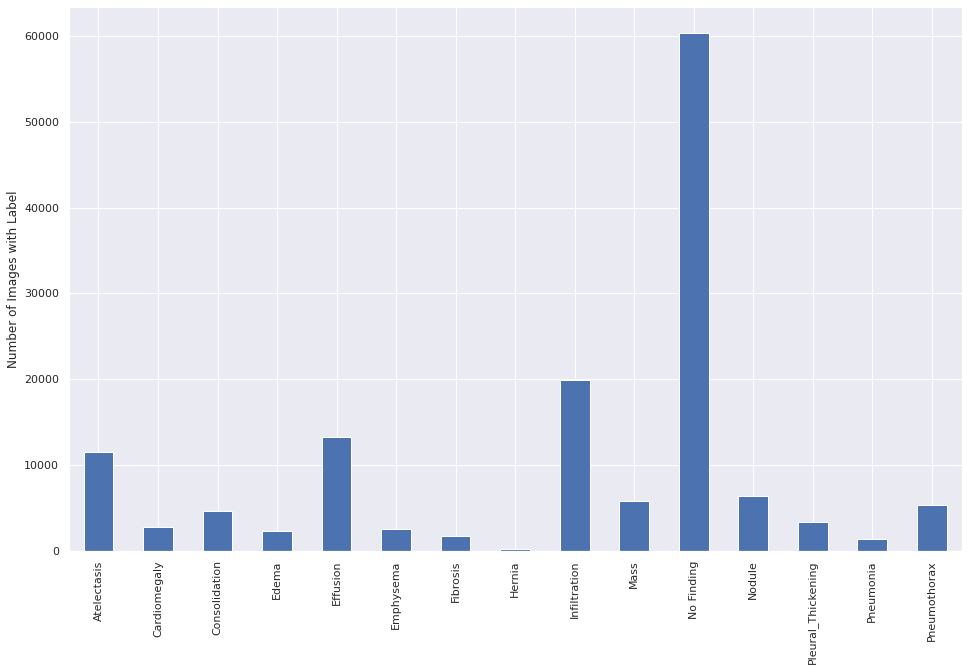

In [21]:
plt.figure(figsize=(16,10))
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

In [22]:
no_finding = all_xray_df[all_xray_df['No Finding']==1]
no_finding.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13,00000005_000.png,No Finding,0,5,69,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14,00000005_001.png,No Finding,1,5,69,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
15,00000005_002.png,No Finding,2,5,69,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16,00000005_003.png,No Finding,3,5,69,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [23]:
print(f"The total patient ids are {no_finding['Patient ID'].count()}, from those the unique ids are {no_finding['Patient ID'].value_counts().shape[0]} ")

The total patient ids are 60361, from those the unique ids are 24907 


In [24]:
pneumonia = all_xray_df[all_xray_df['Pneumonia']==1]
pneumonia.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [25]:
infiltration = all_xray_df[all_xray_df['Infiltration']==1]
infiltration.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19,00000005_006.png,Infiltration,6,5,70,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
20,00000005_007.png,Effusion|Infiltration,7,5,70,F,PA,2566,2681,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
27,00000010_000.png,Infiltration,0,10,84,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
33,00000011_005.png,Infiltration,5,11,75,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
edema = all_xray_df[all_xray_df['Edema']==1]
edema.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
115,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118,00000032_004.png,Cardiomegaly|Edema|Effusion,4,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,00000032_007.png,Cardiomegaly|Edema|Effusion,7,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
137,00000032_023.png,Edema|Infiltration,23,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
atelectasis = all_xray_df[all_xray_df['Atelectasis']==1]
atelectasis.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
34,00000011_006.png,Atelectasis,6,11,75,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,00000013_030.png,Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumo...,30,13,57,M,AP,2500,2048,0.168,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
73,00000013_035.png,Atelectasis|Pneumothorax,35,13,56,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
92,00000019_000.png,Atelectasis|Effusion|Pleural_Thickening,0,19,66,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
111,00000030_000.png,Atelectasis,0,30,74,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
effusion = all_xray_df[all_xray_df['Effusion']==1]
effusion.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,00000005_007.png,Effusion|Infiltration,7,5,70,F,PA,2566,2681,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28,00000011_000.png,Effusion,0,11,75,M,PA,2638,2449,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,00000012_000.png,Effusion|Mass,0,12,76,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
42,00000013_004.png,Effusion|Emphysema|Infiltration|Pneumothorax,4,13,60,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [29]:
cardiomegaly = all_xray_df[all_xray_df['Cardiomegaly']==1]
cardiomegaly.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,00000008_000.png,Cardiomegaly,0,8,69,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,00000013_025.png,Cardiomegaly|Infiltration|Mass|Nodule,25,13,56,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [30]:
consolidation = all_xray_df[all_xray_df['Consolidation']==1]
consolidation.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
130,00000032_016.png,Consolidation,16,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141,00000032_027.png,Cardiomegaly|Consolidation,27,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,00000032_030.png,Cardiomegaly|Consolidation,30,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
152,00000032_038.png,Consolidation|Infiltration,38,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
emphysema = all_xray_df[all_xray_df['Emphysema']==1]
emphysema.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,00000009_000.png,Emphysema,0,9,73,M,PA,2992,2991,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,00000013_001.png,Emphysema|Pneumothorax,1,13,60,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40,00000013_002.png,Emphysema|Pneumothorax,2,13,60,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
42,00000013_004.png,Effusion|Emphysema|Infiltration|Pneumothorax,4,13,60,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [32]:
fibrosis = all_xray_df[all_xray_df['Fibrosis']==1]
fibrosis.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
94,00000020_001.png,Fibrosis|Infiltration,1,20,47,M,PA,2992,2991,0.143,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
95,00000020_002.png,Fibrosis|Infiltration|Pleural_Thickening,2,20,48,M,PA,2414,2991,0.143,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
99,00000022_001.png,Fibrosis,1,22,49,M,PA,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,00000024_000.png,Fibrosis,0,24,52,M,PA,2048,2500,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175,00000033_000.png,Atelectasis|Cardiomegaly|Fibrosis,0,33,72,F,PA,2992,2745,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
hernia = all_xray_df[all_xray_df['Hernia']==1]
hernia.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
mass = all_xray_df[all_xray_df['Mass']==1]
mass.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
12,00000004_000.png,Mass|Nodule,0,4,82,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
37,00000012_000.png,Effusion|Mass,0,12,76,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
60,00000013_022.png,Infiltration|Mass,22,13,56,M,PA,2870,2991,0.143,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
61,00000013_023.png,Infiltration|Mass|Pneumothorax,23,13,57,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
62,00000013_024.png,Mass,24,13,57,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [35]:
nodule = all_xray_df[all_xray_df['Nodule']==1]
nodule.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
12,00000004_000.png,Mass|Nodule,0,4,82,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
25,00000008_002.png,Nodule,2,8,73,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
63,00000013_025.png,Cardiomegaly|Infiltration|Mass|Nodule,25,13,56,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
88,00000017_000.png,Effusion|Infiltration|Nodule,0,17,77,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
96,00000021_000.png,Nodule,0,21,78,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [36]:
pleural_thickening = all_xray_df[all_xray_df['Pleural_Thickening']==1]
pleural_thickening.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
41,00000013_003.png,Pleural_Thickening,3,13,60,M,AP,2996,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
43,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,60,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
47,00000013_009.png,Pleural_Thickening,9,13,60,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
81,00000013_043.png,Mass|Pleural_Thickening,43,13,56,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
82,00000013_044.png,Cardiomegaly|Mass|Pleural_Thickening,44,13,56,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [37]:
pneumothorax = all_xray_df[all_xray_df['Pneumothorax']==1]
pneumothorax.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
39,00000013_001.png,Emphysema|Pneumothorax,1,13,60,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40,00000013_002.png,Emphysema|Pneumothorax,2,13,60,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
42,00000013_004.png,Effusion|Emphysema|Infiltration|Pneumothorax,4,13,60,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
43,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,60,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


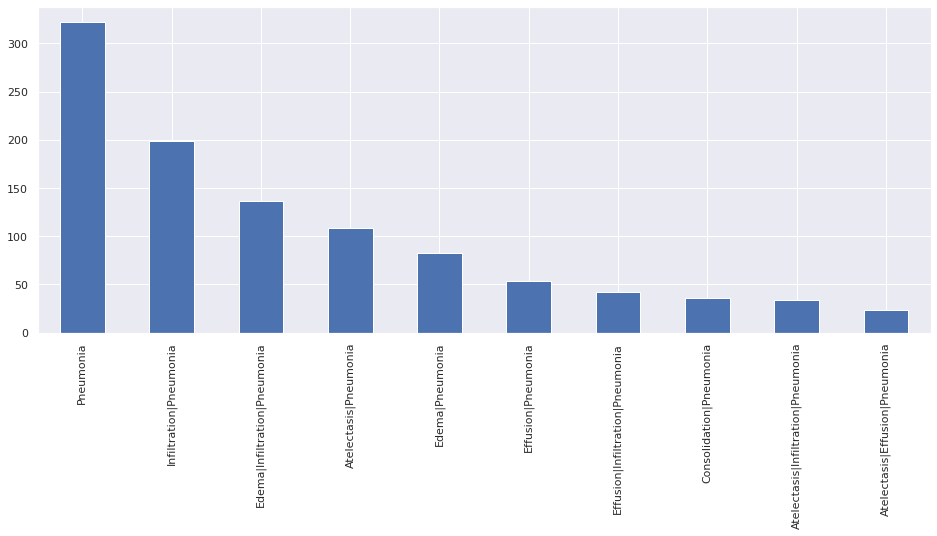

In [38]:
#Since there are many combinations of potential findings, I'm going to look at the 10 most common co-occurrences in Pneumonia:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:10].plot(kind='bar')

**It looks like Pneumonia actually occurs alone for the most part, and that its most-common comorbidities are Infiltration and Edema.**


In [39]:
labels = all_xray_df[['No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']].sum()

In [40]:
labels

No Finding            60361.0
Atelectasis           11559.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2303.0
Effusion              13317.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19894.0
Mass                   5782.0
Nodule                 6331.0
Pleural_Thickening     3385.0
Pneumonia              1431.0
Pneumothorax           5302.0
dtype: float64

In [41]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
81176,00019933_001.png,Atelectasis|Pleural_Thickening,1,19933,69,F,PA,2794,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
85325,00021035_009.png,,9,21035,34,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
41178,00010672_001.png,Atelectasis,1,10672,37,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


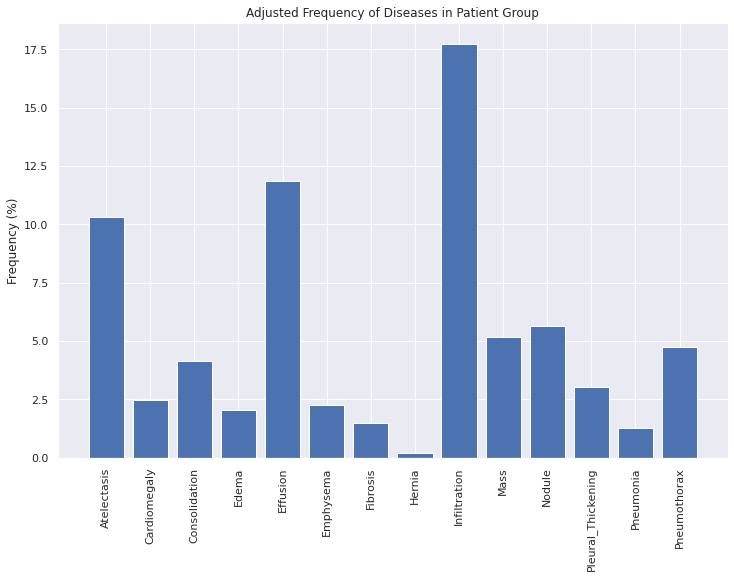

In [42]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')


In [43]:
df = all_xray_df[all_labels]

In [44]:
df.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
columns = df.keys()
columns = list(columns)
print(columns)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [46]:
# Print out the number of positive labels for each class
for column in columns:
    print(f"The class {column} has {df[column].sum()} samples")

The class Atelectasis has 11559.0 samples
The class Cardiomegaly has 2776.0 samples
The class Consolidation has 4667.0 samples
The class Edema has 2303.0 samples
The class Effusion has 13317.0 samples
The class Emphysema has 2516.0 samples
The class Fibrosis has 1686.0 samples
The class Hernia has 227.0 samples
The class Infiltration has 19894.0 samples
The class Mass has 5782.0 samples
The class Nodule has 6331.0 samples
The class Pleural_Thickening has 3385.0 samples
The class Pneumonia has 1431.0 samples
The class Pneumothorax has 5302.0 samples


**We have 1431 samples of Pneumonia positive and 60361 neumonia negative cases in our dataset**

In [47]:
df_pneumonia = all_xray_df[all_xray_df['Pneumonia']==1]
print(df_pneumonia.shape)

(1431, 27)


In [48]:
df_pneumonia.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [49]:
df_pneumonia.tail()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
111557,00030536_007.png,Atelectasis|Consolidation|Pneumonia,7,30536,56,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
111627,00030570_001.png,Edema|Infiltration|Pneumonia,1,30570,29,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
111767,00030621_002.png,Pneumonia,2,30621,22,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
111845,00030637_016.png,Consolidation|Pneumonia,16,30637,48,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [50]:
df_pneumonia.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,1431.000000,1431.000000,1431.000000,1431.000000,1431.000000,1431.000000,1431.000000,0.0,1431.000000,1431.000000,...,1431.000000,1431.000000,1431.000000,1431.000000,1431.000000,1431.0,1431.000000,1431.000000,1431.0,1431.000000
mean,14.429071,14383.761705,44.671558,2668.678546,2442.132075,0.155030,0.155030,NaN,0.183089,0.028651,...,0.016073,0.007687,0.002096,0.422781,0.049616,0.0,0.048917,0.033543,1.0,0.028651
std,20.074835,7977.075197,17.632964,329.134706,388.404275,0.015191,0.015191,NaN,0.386874,0.166883,...,0.125799,0.087368,0.045755,0.494174,0.217225,0.0,0.215770,0.180113,0.0,0.166883
min,0.000000,13.000000,2.000000,1581.000000,1537.000000,0.115000,0.115000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.000000
25%,2.000000,8224.500000,31.000000,2500.000000,2048.000000,0.143000,0.143000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.000000
50%,7.000000,14253.000000,46.000000,2500.000000,2500.000000,0.143000,0.143000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.000000
75%,18.000000,19913.000000,59.000000,2992.000000,2846.000000,0.168000,0.168000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,1.0,0.000000
max,155.000000,30801.000000,90.000000,3056.000000,3056.000000,0.194314,0.194314,NaN,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.0,1.000000


In [51]:
df_pneumonia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1431 entries, 48 to 112115
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  1431 non-null   object 
 1   Finding Labels               1431 non-null   object 
 2   Follow-up #                  1431 non-null   int64  
 3   Patient ID                   1431 non-null   int64  
 4   Patient Age                  1431 non-null   int64  
 5   Patient Gender               1431 non-null   object 
 6   View Position                1431 non-null   object 
 7   OriginalImage[Width          1431 non-null   int64  
 8   Height]                      1431 non-null   int64  
 9   OriginalImagePixelSpacing[x  1431 non-null   float64
 10  y]                           1431 non-null   float64
 11  Unnamed: 11                  0 non-null      float64
 12  Atelectasis                  1431 non-null   float64
 13  Cardiomegaly   

In [52]:
df_pneumonia.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [53]:
df_pneumonia.nunique()

Image Index                    1431
Finding Labels                  142
Follow-up #                      99
Patient ID                     1008
Patient Age                      86
Patient Gender                    2
View Position                     2
OriginalImage[Width             149
Height]                         124
OriginalImagePixelSpacing[x       9
y]                                9
Unnamed: 11                       0
Atelectasis                       2
Cardiomegaly                      2
Consolidation                     2
Edema                             2
Effusion                          2
Emphysema                         2
Fibrosis                          2
Hernia                            2
Infiltration                      2
Mass                              2
No Finding                        1
Nodule                            2
Pleural_Thickening                2
Pneumonia                         1
Pneumothorax                      2
dtype: int64

In [54]:
print(f"The total patient ids are {df_pneumonia['Patient ID'].count()}, from those the unique ids are {df_pneumonia['Patient ID'].value_counts().shape[0]} ")

The total patient ids are 1431, from those the unique ids are 1008 


In [55]:
df_pneumonia.isnull().sum()

Image Index                       0
Finding Labels                    0
Follow-up #                       0
Patient ID                        0
Patient Age                       0
Patient Gender                    0
View Position                     0
OriginalImage[Width               0
Height]                           0
OriginalImagePixelSpacing[x       0
y]                                0
Unnamed: 11                    1431
Atelectasis                       0
Cardiomegaly                      0
Consolidation                     0
Edema                             0
Effusion                          0
Emphysema                         0
Fibrosis                          0
Hernia                            0
Infiltration                      0
Mass                              0
No Finding                        0
Nodule                            0
Pleural_Thickening                0
Pneumonia                         0
Pneumothorax                      0
dtype: int64

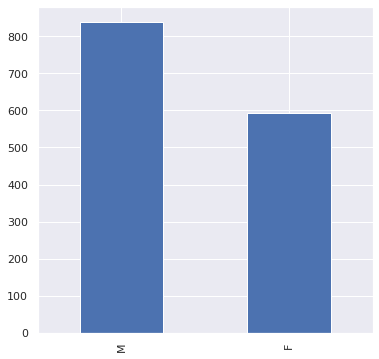

In [56]:
plt.figure(figsize=(6,6))
df_pneumonia['Patient Gender'].value_counts().plot(kind='bar')

(array([ 7., 16., 18., 23., 36., 26., 46., 69., 59., 62., 88., 53., 80.,
        62., 54., 76., 76., 92., 91., 99., 76., 83., 59., 33., 15., 15.,
         9.,  5.,  2.,  1.]),
 array([ 2.        ,  4.93333333,  7.86666667, 10.8       , 13.73333333,
        16.66666667, 19.6       , 22.53333333, 25.46666667, 28.4       ,
        31.33333333, 34.26666667, 37.2       , 40.13333333, 43.06666667,
        46.        , 48.93333333, 51.86666667, 54.8       , 57.73333333,
        60.66666667, 63.6       , 66.53333333, 69.46666667, 72.4       ,
        75.33333333, 78.26666667, 81.2       , 84.13333333, 87.06666667,
        90.        ]),
 <a list of 30 Patch objects>)

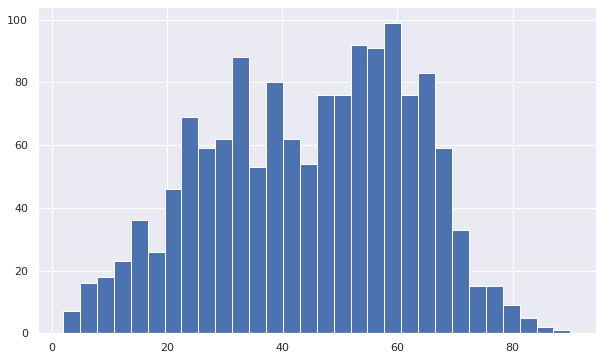

In [57]:
plt.figure(figsize=(10,6))
plt.hist(df_pneumonia['Patient Age'], bins =30)

In [58]:
male_age = df_pneumonia.loc[(all_xray_df["Patient Gender"] == 'M'), "Patient Age"].tolist()
female_age = df_pneumonia.loc[(all_xray_df["Patient Gender"] == 'F'), "Patient Age"].tolist()

(array([ 3.,  5.,  3.,  3., 11.,  3.,  7., 12., 12.,  5., 18., 29., 34.,
        13., 19., 24.,  7., 26., 43.,  9., 22., 27., 15., 11., 26., 34.,
         9., 35., 28., 15., 40., 27., 36., 17., 40., 26., 17., 40., 26.,
        12., 18.,  7.,  4.,  7.,  5.,  3.,  0.,  3.,  1.,  1.]),
 array([ 2. ,  3.7,  5.4,  7.1,  8.8, 10.5, 12.2, 13.9, 15.6, 17.3, 19. ,
        20.7, 22.4, 24.1, 25.8, 27.5, 29.2, 30.9, 32.6, 34.3, 36. , 37.7,
        39.4, 41.1, 42.8, 44.5, 46.2, 47.9, 49.6, 51.3, 53. , 54.7, 56.4,
        58.1, 59.8, 61.5, 63.2, 64.9, 66.6, 68.3, 70. , 71.7, 73.4, 75.1,
        76.8, 78.5, 80.2, 81.9, 83.6, 85.3, 87. ]),
 <a list of 50 Patch objects>)

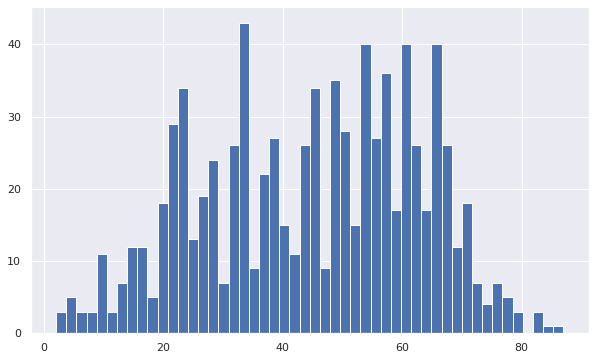

In [59]:
plt.figure(figsize=(10,6))
plt.hist(male_age, bins=50)

(array([ 2.,  5.,  5.,  3.,  6.,  8.,  8.,  9.,  6.,  2.,  7.,  8., 14.,
        19., 13., 13., 23., 22., 15.,  7., 27., 24., 27.,  8., 21., 27.,
        15., 14., 26., 24., 23., 28., 23., 19., 14., 13., 20., 14.,  3.,
         8.,  5.,  4.,  2.,  1.,  5.,  1.,  0.,  1.,  0.,  1.]),
 array([ 3.  ,  4.74,  6.48,  8.22,  9.96, 11.7 , 13.44, 15.18, 16.92,
        18.66, 20.4 , 22.14, 23.88, 25.62, 27.36, 29.1 , 30.84, 32.58,
        34.32, 36.06, 37.8 , 39.54, 41.28, 43.02, 44.76, 46.5 , 48.24,
        49.98, 51.72, 53.46, 55.2 , 56.94, 58.68, 60.42, 62.16, 63.9 ,
        65.64, 67.38, 69.12, 70.86, 72.6 , 74.34, 76.08, 77.82, 79.56,
        81.3 , 83.04, 84.78, 86.52, 88.26, 90.  ]),
 <a list of 50 Patch objects>)

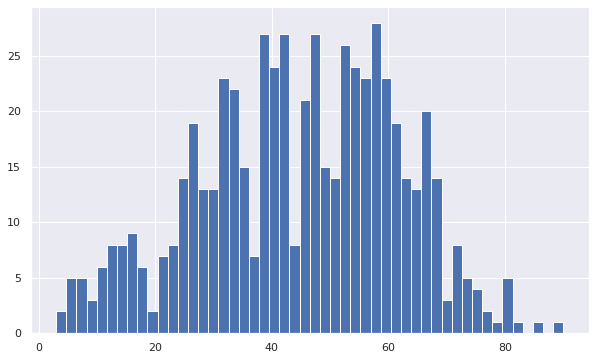

In [60]:
plt.figure(figsize=(10,6))
plt.hist(female_age, bins=50)

(array([648., 222., 155.,  92.,  62.,  50.,  44.,  29.,  16.,  15.,  15.,
         19.,  16.,   8.,  13.,   4.,   3.,   4.,   1.,   6.,   2.,   4.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.]),
 array([  0.        ,   5.16666667,  10.33333333,  15.5       ,
         20.66666667,  25.83333333,  31.        ,  36.16666667,
         41.33333333,  46.5       ,  51.66666667,  56.83333333,
         62.        ,  67.16666667,  72.33333333,  77.5       ,
         82.66666667,  87.83333333,  93.        ,  98.16666667,
        103.33333333, 108.5       , 113.66666667, 118.83333333,
        124.        , 129.16666667, 134.33333333, 139.5       ,
        144.66666667, 149.83333333, 155.        ]),
 <a list of 30 Patch objects>)

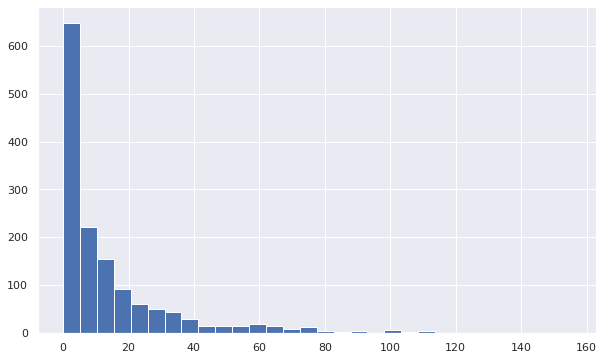

In [61]:
plt.figure(figsize=(10,6))
plt.hist(df_pneumonia['Follow-up #'], bins=30)

(array([801.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 630.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

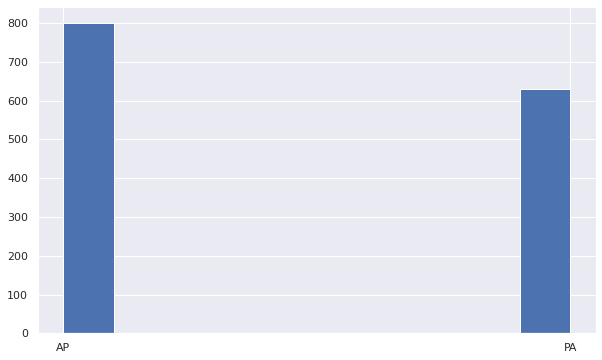

In [62]:
plt.figure(figsize=(10,6))
plt.hist(df_pneumonia['View Position'])

In [63]:
df_pneumonia_1 = df_pneumonia[['Follow-up #', 'Patient Age', 'Patient Gender', 'View Position', 'Pneumonia']]

In [64]:
df_pneumonia_1.head()

,Follow-up #,Patient Age,Patient Gender,View Position,Pneumonia
48,10,60,M,AP,1.0
126,12,55,F,AP,1.0
253,0,76,M,PA,1.0
276,12,77,M,AP,1.0
279,15,77,M,AP,1.0


In [65]:
df_pneumonia_1.describe()

,Follow-up #,Patient Age,Pneumonia
count,1431.000000,1431.000000,1431.0
mean,14.429071,44.671558,1.0
std,20.074835,17.632964,0.0
min,0.000000,2.000000,1.0
25%,2.000000,31.000000,1.0
50%,7.000000,46.000000,1.0
75%,18.000000,59.000000,1.0
max,155.000000,90.000000,1.0


In [66]:
corelation = df_pneumonia_1.corr()

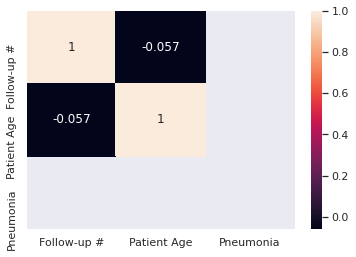

In [67]:
sns.heatmap(corelation, xticklabels=corelation.columns, yticklabels=corelation.columns, annot=True)

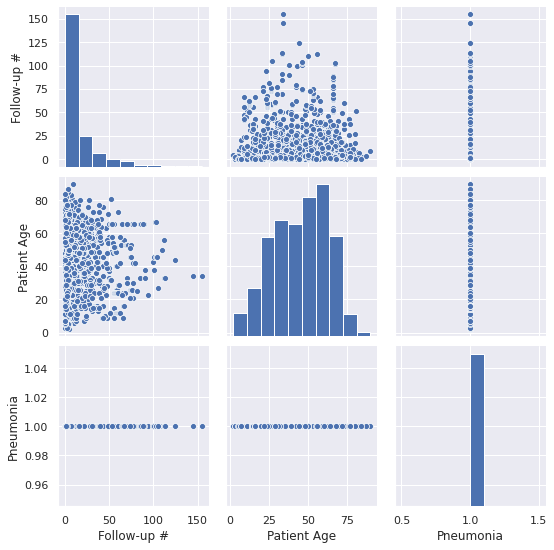

In [68]:
sns.pairplot(df_pneumonia_1)

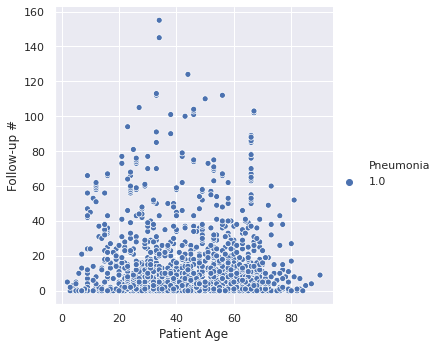

In [69]:
sns.relplot(x= 'Patient Age', y='Follow-up #', hue='Pneumonia', data=df_pneumonia_1)

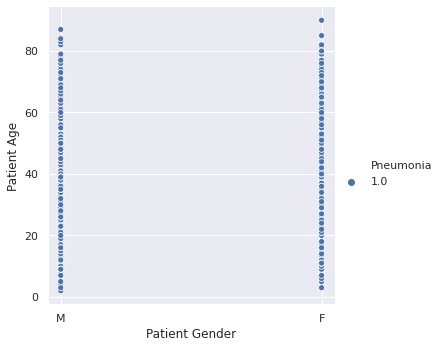

In [70]:
sns.relplot(x= 'Patient Gender', y='Patient Age', hue='Pneumonia', data=df_pneumonia_1)

In [71]:
#this dataset has 'path' column which we need for finding image path
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x):x for x in
                  glob(os.path.join('/data', 'images*','*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path']= all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
13262,00003446_010.png,No Finding,10,3446,49,M,AP,2500,2048,0.171,0.171,NaN,/data/images_002/images/00003446_010.png
78583,00019271_066.png,No Finding,66,19271,55,M,AP,2500,2048,0.168,0.168,NaN,/data/images_009/images/00019271_066.png
4454,00001205_004.png,No Finding,4,1205,43,F,PA,2048,2500,0.168,0.168,NaN,/data/images_001/images/00001205_004.png


In [72]:
all_xray_df['path']

0         /data/images_001/images/00000001_000.png
1         /data/images_001/images/00000001_001.png
2         /data/images_001/images/00000001_002.png
3         /data/images_001/images/00000002_000.png
4         /data/images_001/images/00000003_000.png
                            ...                   
112115    /data/images_012/images/00030801_001.png
112116    /data/images_012/images/00030802_000.png
112117    /data/images_012/images/00030803_000.png
112118    /data/images_012/images/00030804_000.png
112119    /data/images_012/images/00030805_000.png
Name: path, Length: 112120, dtype: object

In [73]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  path                         112120 non-null  object 
dtyp

In [74]:
pneumonia_img = all_xray_df[all_xray_df['Image Index']== '00000061_015.png']
pneumonia_img

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000061_015.png


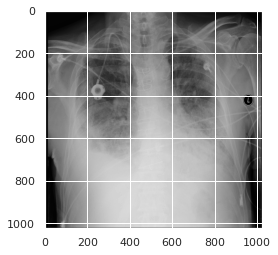

In [75]:
pneumonia_img = plt.imread('/data/images_001/images/00000061_015.png')
plt.imshow(pneumonia_img, cmap='gray')

In [76]:
print(type(pneumonia_img))

<class 'numpy.ndarray'>


In [77]:
pneumonia_img=np.array(pneumonia_img)

In [78]:
print(type(pneumonia_img))

<class 'numpy.ndarray'>


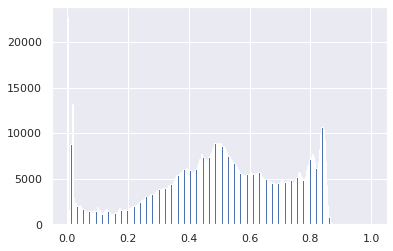

In [79]:
pneumonia_img = plt.hist(pneumonia_img.ravel(),bins=256)

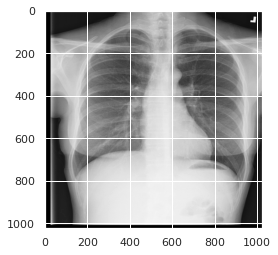

In [80]:
healthy_img = plt.imread('/data/images_003/images/00006164_000.png')
plt.imshow(healthy_img,cmap='gray')

In [81]:
healthy_img=np.array(healthy_img)

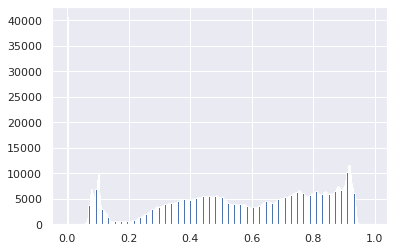

In [82]:
healthy_img = plt.hist(healthy_img.ravel(),bins=256)

In [83]:
atelectasis_img = all_xray_df[all_xray_df['Image Index']== '00000011_006.png']
atelectasis_img

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
34,00000011_006.png,Atelectasis,6,11,75,M,PA,2992,2991,0.143,0.143,NaN,/data/images_001/images/00000011_006.png


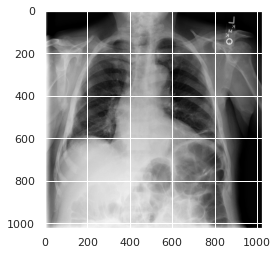

In [84]:
atelectasis_img = plt.imread('/data/images_001/images/00000011_006.png')
plt.imshow(atelectasis_img, cmap='gray')

In [85]:
atelectasis_img=np.array(atelectasis_img)

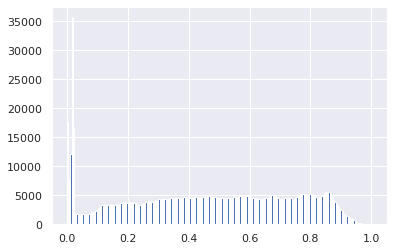

In [86]:
atelectasis_img = plt.hist(atelectasis_img.ravel(),bins=256)

In [87]:
cardiomegaly_img = all_xray_df[all_xray_df['Image Index']== '00000001_000.png']
cardiomegaly_img

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png


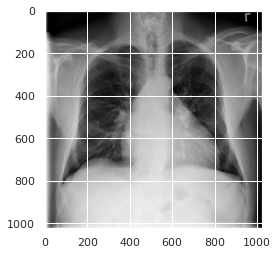

In [88]:
cardiomegaly_img = plt.imread('/data/images_001/images/00000001_000.png')
plt.imshow(cardiomegaly_img, cmap='gray')

In [89]:
cardiomegaly_img=np.array(cardiomegaly_img)

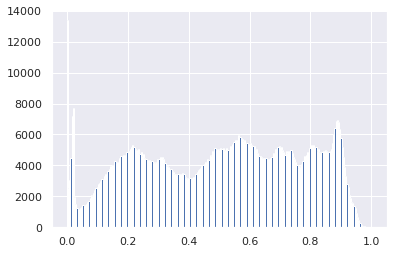

In [90]:
cardiomegaly_img = plt.hist(cardiomegaly_img.ravel(),bins=256)

In [91]:
consolidation_img = all_xray_df[all_xray_df['Image Index']== '00000032_016.png']
consolidation_img

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
130,00000032_016.png,Consolidation,16,32,55,F,AP,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000032_016.png


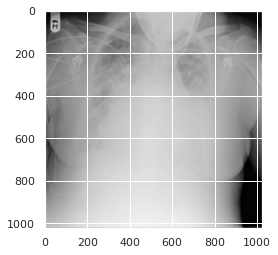

In [92]:
consolidation_img = plt.imread('/data/images_001/images/00000032_016.png')
plt.imshow(consolidation_img, cmap='gray')

In [93]:
consolidation_img=np.array(consolidation_img)

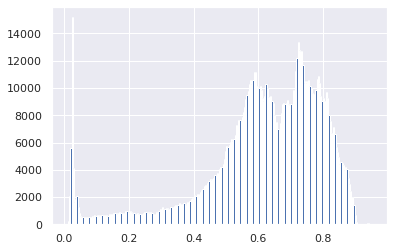

In [94]:
consolidation_img = plt.hist(consolidation_img.ravel(),bins=256)

In [95]:
edema_img = all_xray_df[all_xray_df['Image Index']== '00000032_023.png']
edema_img

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
137,00000032_023.png,Edema|Infiltration,23,32,55,F,AP,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000032_023.png


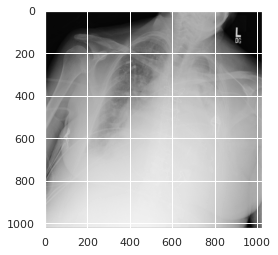

In [96]:
edema_img = plt.imread('/data/images_001/images/00000032_023.png')
plt.imshow(edema_img, cmap='gray')

In [97]:
edema_img=np.array(edema_img)

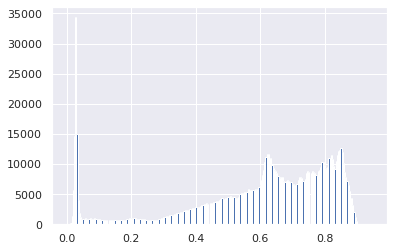

In [98]:
edema_img = plt.hist(edema_img.ravel(),bins=256)

In [99]:
effusion_img = all_xray_df[all_xray_df['Image Index']== '00000011_000.png']
effusion_img

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
28,00000011_000.png,Effusion,0,11,75,M,PA,2638,2449,0.143,0.143,NaN,/data/images_001/images/00000011_000.png


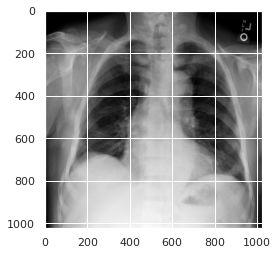

In [100]:
effusion_img = plt.imread('/data/images_001/images/00000011_000.png')
plt.imshow(effusion_img, cmap='gray')

In [101]:
effusion_img=np.array(effusion_img)

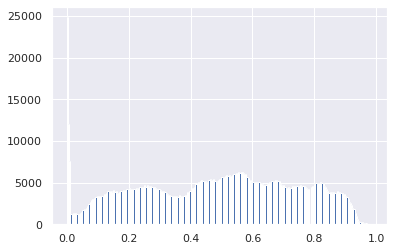

In [102]:
effusion_img = plt.hist(effusion_img.ravel(),bins=256)

In [103]:
emphysema_img = all_xray_df[all_xray_df['Image Index']== '00000009_000.png']
emphysema_img

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
26,00000009_000.png,Emphysema,0,9,73,M,PA,2992,2991,0.143,0.143,NaN,/data/images_001/images/00000009_000.png


In [104]:
emphysema_img=np.array(emphysema_img)

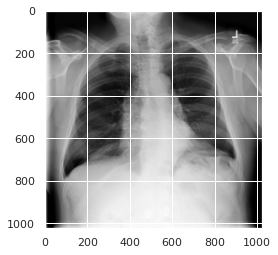

In [105]:
emphysema_img = plt.imread('/data/images_001/images/00000009_000.png')
plt.imshow(emphysema_img, cmap='gray')

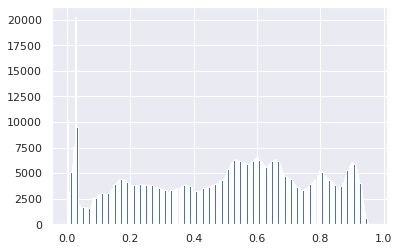

In [106]:
emplysema_img = plt.hist(emphysema_img.ravel(),bins=256)

In [107]:
fibrosis_img = all_xray_df[all_xray_df['Image Index']== '00000024_000.png']
fibrosis_img

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
105,00000024_000.png,Fibrosis,0,24,52,M,PA,2048,2500,0.168,0.168,NaN,/data/images_001/images/00000024_000.png


In [108]:
fibrosis_img=np.array(fibrosis_img)

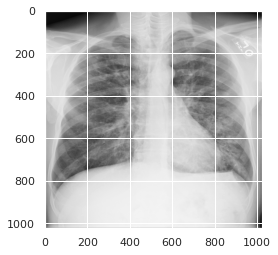

In [109]:
fibrosis_img = plt.imread('/data/images_001/images/00000024_000.png')
plt.imshow(fibrosis_img, cmap='gray')

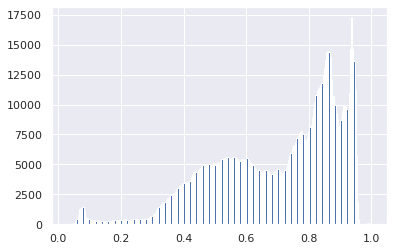

In [110]:
fibrosis_img = plt.hist(fibrosis_img.ravel(),bins=256)

In [111]:
hernia_img = all_xray_df[all_xray_df['Image Index']== '00000003_004.png']
fibrosis_img

(array([2.1000e+01, 3.3000e+01, 4.3000e+01, 3.7000e+01, 2.6000e+01,
        1.0100e+02, 1.2700e+02, 2.5600e+02, 4.4100e+02, 7.5200e+02,
        1.2460e+03, 1.3250e+03, 1.3520e+03, 1.4300e+03, 1.2130e+03,
        6.0600e+02, 4.3600e+02, 5.0000e+02, 4.6900e+02, 3.7800e+02,
        3.8700e+02, 3.5900e+02, 3.1500e+02, 3.3800e+02, 3.0200e+02,
        3.4200e+02, 2.9400e+02, 3.1100e+02, 2.6700e+02, 2.9100e+02,
        2.5900e+02, 0.0000e+00, 2.8700e+02, 2.8400e+02, 2.8300e+02,
        2.9000e+02, 3.1200e+02, 3.1100e+02, 3.5000e+02, 3.6300e+02,
        3.3700e+02, 3.5900e+02, 3.7100e+02, 3.4900e+02, 3.8400e+02,
        3.7500e+02, 3.5400e+02, 3.9500e+02, 4.0900e+02, 4.0500e+02,
        3.5900e+02, 3.6400e+02, 3.7900e+02, 4.0100e+02, 3.7800e+02,
        3.9000e+02, 4.2700e+02, 3.9800e+02, 4.5700e+02, 3.8900e+02,
        4.2600e+02, 4.0500e+02, 4.4100e+02, 0.0000e+00, 4.6000e+02,
        4.8400e+02, 4.6400e+02, 5.4300e+02, 5.1300e+02, 6.2100e+02,
        7.0100e+02, 7.2300e+02, 8.7200e+02, 9.73

In [112]:
hernia_img=np.array(hernia_img)

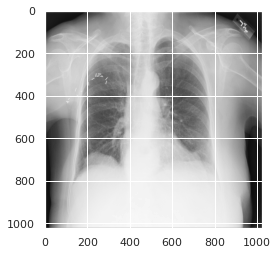

In [113]:
hernia_img = plt.imread('/data/images_001/images/00000003_004.png')
plt.imshow(hernia_img, cmap='gray')

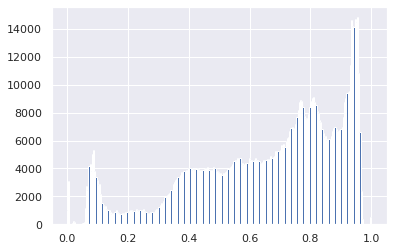

In [114]:
hernia_img = plt.hist(hernia_img.ravel(),bins=256)

In [115]:
infiltration_img = all_xray_df[all_xray_df['Image Index']== '00000011_005.png']
infiltration_img

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
33,00000011_005.png,Infiltration,5,11,75,M,AP,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000011_005.png


In [116]:
infiltration_img=np.array(infiltration_img)

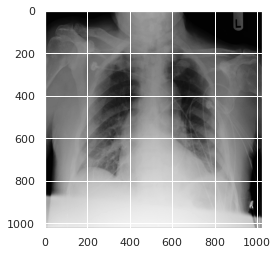

In [117]:
infiltration_img = plt.imread('/data/images_001/images/00000011_005.png')
plt.imshow(infiltration_img, cmap='gray')

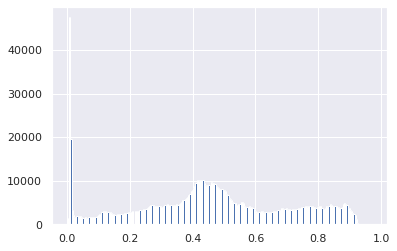

In [118]:
infiltration_img = plt.hist(infiltration_img.ravel(),bins=256)

In [119]:
mass_img = all_xray_df[all_xray_df['Image Index']== '00000013_024.png']
mass_img

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
62,00000013_024.png,Mass,24,13,57,M,AP,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000013_024.png


In [120]:
mass_img=np.array(mass_img)

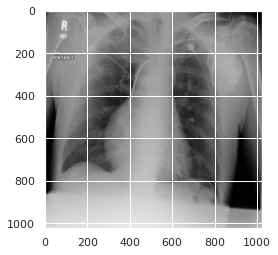

In [121]:
mass_img = plt.imread('/data/images_001/images/00000013_024.png')
plt.imshow(mass_img, cmap='gray')

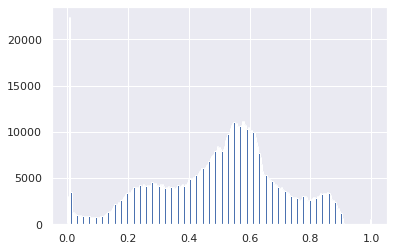

In [122]:
mass_img = plt.hist(mass_img.ravel(),bins=256)

In [123]:
nodule_img = all_xray_df[all_xray_df['Image Index']== '00000008_002.png']
nodule_img

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
25,00000008_002.png,Nodule,2,8,73,F,PA,2048,2500,0.168,0.168,NaN,/data/images_001/images/00000008_002.png


In [124]:
nodule_img=np.array(nodule_img)

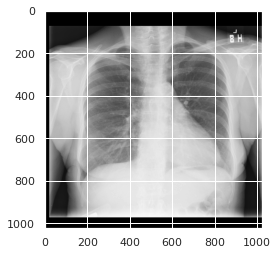

In [125]:
nodule_img = plt.imread('/data/images_001/images/00000008_002.png')
plt.imshow(nodule_img, cmap='gray')

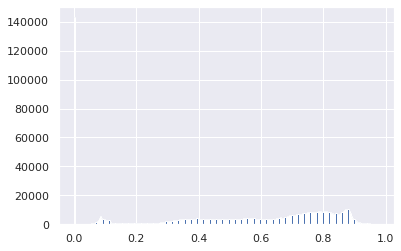

In [126]:
nodule_img = plt.hist(nodule_img.ravel(),bins=256)

In [127]:
pleural_thickening_img = all_xray_df[all_xray_df['Image Index']== '00000013_003.png']
pleural_thickening_img

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
41,00000013_003.png,Pleural_Thickening,3,13,60,M,AP,2996,2544,0.139,0.139,NaN,/data/images_001/images/00000013_003.png


In [128]:
pleural_thickening_img=np.array(pleural_thickening_img)

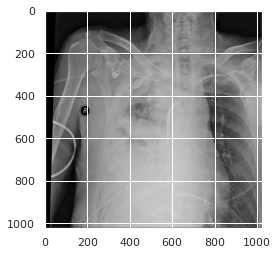

In [129]:
pleural_thickening_img = plt.imread('/data/images_001/images/00000013_003.png')
plt.imshow(pleural_thickening_img, cmap='gray')

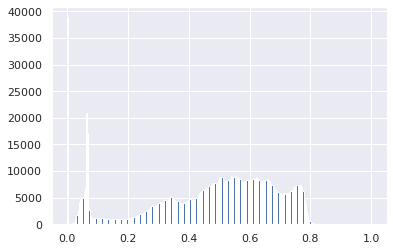

In [130]:
pleural_thickening_img = plt.hist(pleural_thickening_img.ravel(),bins=256)

In [131]:
pneumothorax_img = all_xray_df[all_xray_df['Image Index']== '00000013_001.png']
pneumothorax_img

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
39,00000013_001.png,Emphysema|Pneumothorax,1,13,60,M,AP,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000013_001.png


In [132]:
pneumothorax_img=np.array(pneumothorax_img)

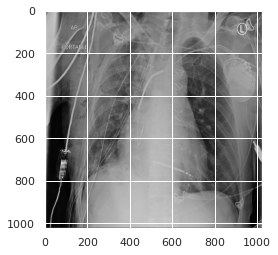

In [133]:
pneumothorax_img = plt.imread('/data/images_001/images/00000013_001.png')
plt.imshow(pneumothorax_img, cmap='gray')

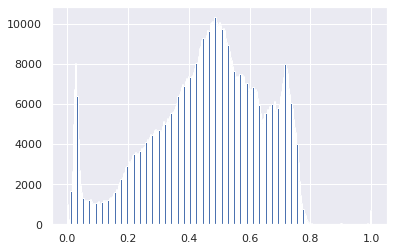

In [134]:
pneumothorax_img = plt.hist(pneumothorax_img.ravel(),bins=256)

MY OBSERVATION ABOUT IMAGE INTENITY VALUES:

* The intensity histograms are not very consistent, so thresholding the identify Pneumonia would likely not be effective. We also see that for most images, the black border strongly effects the intensity statistics and produces a peak at the left side of the chart.

* To address these issues, we may apply data augmentation to the training dataset including random cropping, zoom, shear, and saturation transformations. 


In [135]:
sample_df.head()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [136]:
sample_df.shape

(5606, 11)

In [137]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


In [138]:
sample_df.describe()

,Follow-up #,Patient ID,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
count,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000
mean,8.616661,14330.617017,2644.795755,2491.087406,0.155467,0.155467
std,15.565815,8411.477789,347.188754,399.119063,0.016201,0.016201
min,0.000000,13.000000,1362.000000,966.000000,0.115000,0.115000
25%,0.000000,7289.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,2542.000000,2544.000000,0.143000,0.143000
75%,10.000000,20655.500000,2992.000000,2991.000000,0.168000,0.168000
max,177.000000,30797.000000,3266.000000,3056.000000,0.198800,0.198800


In [139]:
columns = sample_df.keys()
columns = list(columns)
print(columns)

['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth', 'OriginalImageHeight', 'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y']


In [140]:
sample_df.rename(columns={'Image Index':'Image'}, inplace=True)

In [141]:
columns = sample_df.keys()
columns = list(columns)
print(columns)

['Image', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth', 'OriginalImageHeight', 'OriginalImagePixelSpacing_x', 'OriginalImagePixelSpacing_y']


In [142]:
print(f"The total patient ids are {sample_df['Patient ID'].count()}, from those the unique ids are {sample_df['Patient ID'].value_counts().shape[0]} ")

The total patient ids are 5606, from those the unique ids are 4230 


In [143]:
# Here I will split up my "Finding Labels" column so that I have one column in my dataframe
# per disease, with a binary flag. This makes EDA a lot easier!
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:

    if len(c_label)>1: # leave out empty labels

        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

sample_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
2522,00012667_000.png,Pneumonia,0,12667,007Y,F,PA,1804,1685,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3921,00019363_017.png,Consolidation,17,19363,055Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4589,00022883_002.png,Atelectasis|Effusion|Infiltration,2,22883,067Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
sample_df[all_labels].sum()/len(sample_df)

Atelectasis           0.090617
Cardiomegaly          0.025152
Consolidation         0.040314
Edema                 0.021049
Effusion              0.114877
Emphysema             0.022654
Fibrosis              0.014984
Hernia                0.002319
Infiltration          0.172494
Mass                  0.050660
No Finding            0.542990
Nodule                0.055833
Pleural_Thickening    0.031395
Pneumonia             0.011060
Pneumothorax          0.048341
dtype: float64

In [145]:
labels = sample_df[['No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']].sum()

In [146]:
labels

No Finding            3044.0
Atelectasis            508.0
Cardiomegaly           141.0
Consolidation          226.0
Edema                  118.0
Effusion               644.0
Emphysema              127.0
Fibrosis                84.0
Hernia                  13.0
Infiltration           967.0
Mass                   284.0
Nodule                 313.0
Pleural_Thickening     176.0
Pneumonia               62.0
Pneumothorax           271.0
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

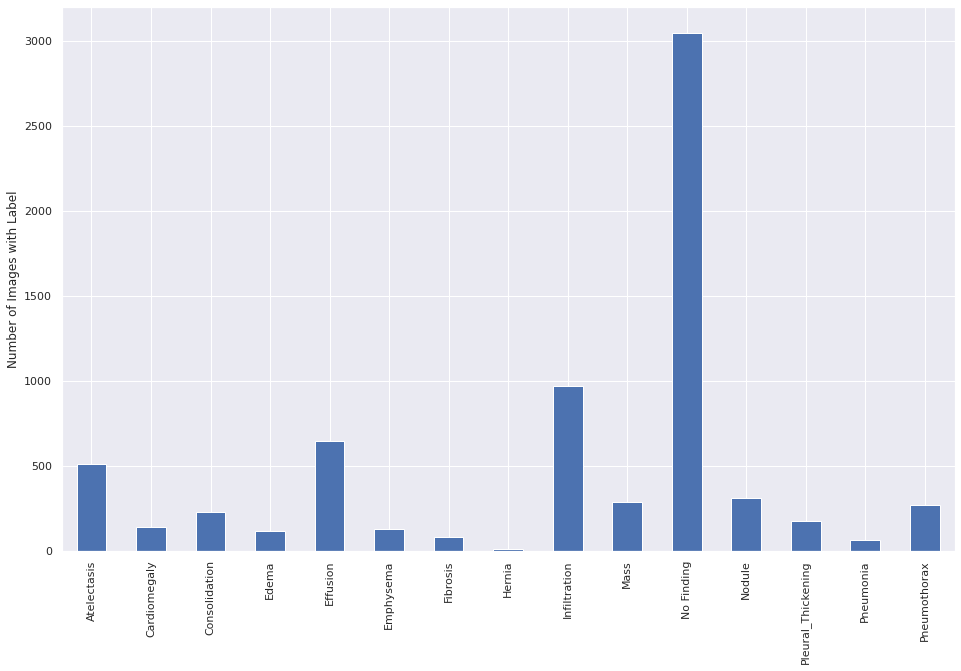

In [147]:
plt.figure(figsize=(16,10))
ax = sample_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

There are only 62 samples of pneumonia is sample_df and 3044 samples of 'no finding' (healty).
I will build a model from the dataset all_xray_df as it has more samples of pneumonia.

## Now I will try to read in dicom file

In [148]:
import pydicom

In [149]:
dcm1 = pydicom.dcmread('test1.dcm')

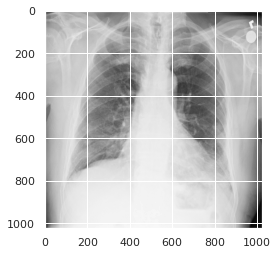

In [150]:
plt.imshow(dcm1.pixel_array,cmap='gray')

In [151]:
#Find the mean and std dev intensity values of the image, and standerdize it
mean_intensity = np.mean(dcm1.pixel_array)
mean_intensity

180.0586576461792

In [152]:
std_intensity = np.std(dcm1.pixel_array)
std_intensity

47.89115072730743

In [153]:
new_img1 = dcm1.pixel_array.copy()
new_img1 = (new_img1 - mean_intensity)/std_intensity

(array([2.4090e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5000e+01,
        5.1900e+02, 7.5000e+02, 6.9700e+02, 7.2200e+02, 8.0100e+02,
        8.5400e+02, 2.9900e+02, 9.6000e+01, 5.6000e+01, 5.9000e+01,
        6.9000e+01, 5.9000e+01, 7.1000e+01, 7.1000e+01, 7.3000e+01,
        8.3000e+01, 8.5000e+01, 9.7000e+01, 1.6800e+02, 1.5600e+02,
        1.3300e+02, 1.2700e+02, 1.2300e+02, 1.1600e+02, 1.1500e+02,
        1.0900e+02, 1.0700e+02, 1.0700e+02, 1.0500e+02, 1.0200e+02,
        1.2400e+02, 1.1000e+02, 1.0500e+02, 1.1900e+02, 1.3700e+02,
        1.3400e+02, 1.4600e+02, 1.7300e+02, 1.5000e+02, 1.5000e+02,
        1.5600e+02, 1.9100e+02, 1.9500e+02, 2.4200e+02, 2.9500e+02,
        2.9200e+02, 3.4600e+02, 4.0000e+02, 3.9900e+02, 4.3000e+02,
        4.9500e+02, 5.3700e+02, 5.6300e+02, 0.0000e+00, 7.1100e+02,
        6.9100e+02, 7.3300e+02, 7.4600e+02, 8.5700e+02, 9.7200e+02,
        1.0050e+03, 1.0940e+03, 1.1660e+03, 1.22

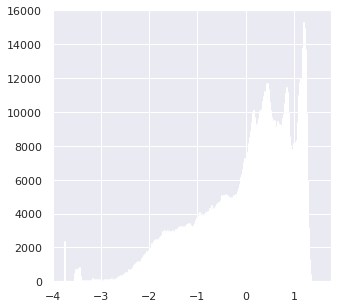

In [154]:
#Re-plot a histogram of the normalized intensity values
plt.figure(figsize=(5,5))
plt.hist(new_img1.ravel(), bins = 256)

In [155]:
#Now I will read in the 2nd dicom file :
dcm2 = pydicom.dcmread('test2.dcm')

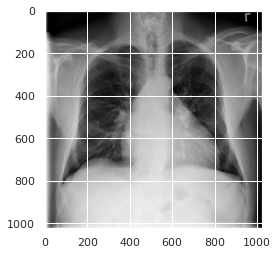

In [156]:
plt.imshow(dcm2.pixel_array,cmap='gray')

(array([13386.,  2532.,  3043.,  4455.,  7220.,  7741.,  1954.,  1499.,
         1278.,  1154.,  1208.,  1226.,  1329.,  1421.,  1385.,  1449.,
         1521.,  1662.,  1678.,  1892.,  2060.,  2038.,  2205.,  2404.,
         2561.,  2628.,  2800.,  2834.,  3012.,  3106.,  3086.,  3300.,
         3427.,  3422.,  3636.,  3759.,  3973.,  3954.,  4013.,  4040.,
         4284.,  4169.,  4200.,  4232.,  4474.,  4588.,  4616.,  4695.,
         4691.,  4671.,  4842.,  4959.,  4900.,  5059.,  5207.,  5314.,
         5165.,  5089.,  5027.,  5015.,  5077.,  4751.,  4851.,  4585.,
         4714.,  4449.,  4438.,  4351.,  4327.,  4348.,  4285.,  4302.,
         4170.,  4235.,  4150.,  4249.,  4405.,  4410.,  4567.,  4570.,
         4531.,  4431.,  4186.,  3957.,  3985.,  3871.,  3711.,  3778.,
         3607.,  3584.,  3420.,  3416.,  3370.,  3459.,  3426.,  3422.,
         3441.,  3493.,  3457.,  3277.,  3184.,  3147.,  3180.,  3165.,
         3112.,  3213.,  3232.,  3260.,  3445.,  3550.,  3683., 

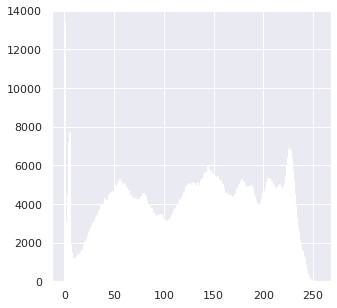

In [157]:
#plot a histogram of the image pixel intensity values
plt.figure(figsize=(5,5))
plt.hist(dcm2.pixel_array.ravel(), bins = 256)

In [158]:
#Find the mean and std dev intensity values of the image, and standerdize it
mean_intensity = np.mean(dcm2.pixel_array)
mean_intensity

128.13570880889893

In [159]:
std_intensity = np.std(dcm2.pixel_array)
std_intensity


67.42323200014457

In [160]:
new_img2 = dcm2.pixel_array.copy()
new_img2 = (new_img2 - mean_intensity)/std_intensity

(array([13386.,  2532.,  3043.,  4455.,  7220.,  7741.,  1954.,  1499.,
         1278.,  1154.,  1208.,  1226.,  1329.,  1421.,  1385.,  1449.,
         1521.,  1662.,  1678.,  1892.,  2060.,  2038.,  2205.,  2404.,
         2561.,  2628.,  2800.,  2834.,  3012.,  3106.,  3086.,  3300.,
         3427.,  3422.,  3636.,  3759.,  3973.,  3954.,  4013.,  4040.,
         4284.,  4169.,  4200.,  4232.,  4474.,  4588.,  4616.,  4695.,
         4691.,  4671.,  4842.,  4959.,  4900.,  5059.,  5207.,  5314.,
         5165.,  5089.,  5027.,  5015.,  5077.,  4751.,  4851.,  4585.,
         4714.,  4449.,  4438.,  4351.,  4327.,  4348.,  4285.,  4302.,
         4170.,  4235.,  4150.,  4249.,  4405.,  4410.,  4567.,  4570.,
         4531.,  4431.,  4186.,  3957.,  3985.,  3871.,  3711.,  3778.,
         3607.,  3584.,  3420.,  3416.,  3370.,  3459.,  3426.,  3422.,
         3441.,  3493.,  3457.,  3277.,  3184.,  3147.,  3180.,  3165.,
         3112.,  3213.,  3232.,  3260.,  3445.,  3550.,  3683., 

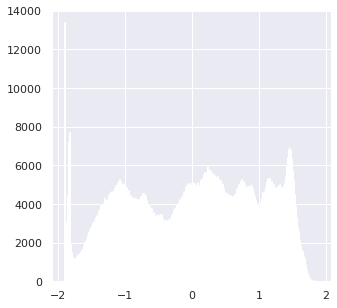

In [161]:
#Re-plot a histogram of the normalized intensity values
plt.figure(figsize=(5,5))
plt.hist(new_img2.ravel(), bins = 256)

In [162]:
#Now I will read in the 3rd dicom file :
dcm3 = pydicom.dcmread('test3.dcm')

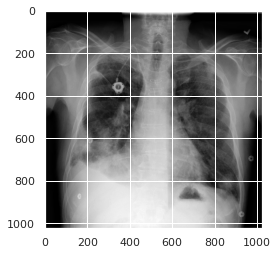

In [163]:
plt.imshow(dcm3.pixel_array,cmap='gray')

(array([3.5061e+04, 8.4770e+03, 1.1659e+04, 1.5547e+04, 2.6001e+04,
        1.2153e+04, 2.3590e+03, 2.1880e+03, 2.2290e+03, 2.0000e+03,
        1.8530e+03, 1.7710e+03, 1.7830e+03, 1.8510e+03, 1.9450e+03,
        1.8240e+03, 1.8270e+03, 1.8310e+03, 1.8620e+03, 1.8820e+03,
        2.1060e+03, 2.0850e+03, 2.1490e+03, 2.2610e+03, 2.3450e+03,
        0.0000e+00, 2.3700e+03, 2.4940e+03, 2.7080e+03, 2.7610e+03,
        2.9390e+03, 2.9560e+03, 2.9950e+03, 3.0180e+03, 3.0560e+03,
        3.2820e+03, 3.3430e+03, 3.4600e+03, 3.5090e+03, 3.7450e+03,
        3.7580e+03, 3.8000e+03, 4.0730e+03, 4.3480e+03, 4.4720e+03,
        4.4720e+03, 4.7580e+03, 4.7250e+03, 4.8530e+03, 4.8440e+03,
        4.8640e+03, 0.0000e+00, 4.8580e+03, 5.0440e+03, 5.1020e+03,
        5.2790e+03, 5.2400e+03, 5.4470e+03, 5.5970e+03, 5.4190e+03,
        5.4440e+03, 5.3410e+03, 5.4730e+03, 5.4880e+03, 5.6010e+03,
        5.7700e+03, 5.7040e+03, 5.7260e+03, 5.8040e+03, 5.8610e+03,
        6.0650e+03, 5.9290e+03, 5.8920e+03, 5.86

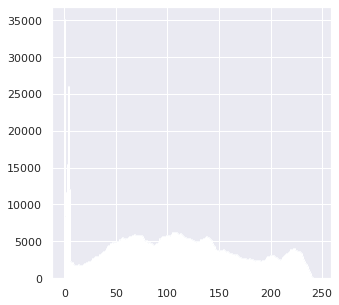

In [164]:
#plot a histogram of the image pixel intensity values
plt.figure(figsize=(5,5))
plt.hist(dcm3.pixel_array.ravel(), bins = 256)

In [165]:
#Find the mean and std dev intensity values of the image, and standerdize it
mean_intensity = np.mean(dcm3.pixel_array)
mean_intensity

104.74800395965576

In [166]:
std_intensity = np.std(dcm3.pixel_array)
std_intensity

66.22413614301003

In [167]:
new_img3 = dcm3.pixel_array.copy()
new_img3 = (new_img3 - mean_intensity)/std_intensity

(array([3.5061e+04, 8.4770e+03, 1.1659e+04, 1.5547e+04, 2.6001e+04,
        1.2153e+04, 2.3590e+03, 2.1880e+03, 2.2290e+03, 2.0000e+03,
        1.8530e+03, 1.7710e+03, 1.7830e+03, 1.8510e+03, 1.9450e+03,
        1.8240e+03, 1.8270e+03, 1.8310e+03, 1.8620e+03, 1.8820e+03,
        2.1060e+03, 2.0850e+03, 2.1490e+03, 2.2610e+03, 2.3450e+03,
        0.0000e+00, 2.3700e+03, 2.4940e+03, 2.7080e+03, 2.7610e+03,
        2.9390e+03, 2.9560e+03, 2.9950e+03, 3.0180e+03, 3.0560e+03,
        3.2820e+03, 3.3430e+03, 3.4600e+03, 3.5090e+03, 3.7450e+03,
        3.7580e+03, 3.8000e+03, 4.0730e+03, 4.3480e+03, 4.4720e+03,
        4.4720e+03, 4.7580e+03, 4.7250e+03, 4.8530e+03, 4.8440e+03,
        4.8640e+03, 0.0000e+00, 4.8580e+03, 5.0440e+03, 5.1020e+03,
        5.2790e+03, 5.2400e+03, 5.4470e+03, 5.5970e+03, 5.4190e+03,
        5.4440e+03, 5.3410e+03, 5.4730e+03, 5.4880e+03, 5.6010e+03,
        5.7700e+03, 5.7040e+03, 5.7260e+03, 5.8040e+03, 5.8610e+03,
        6.0650e+03, 5.9290e+03, 5.8920e+03, 5.86

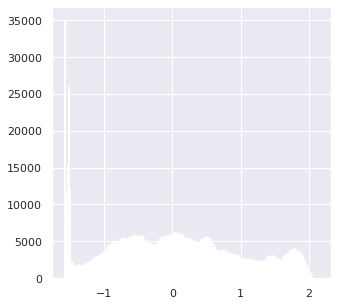

In [168]:
#Re-plot a histogram of the normalized intensity values
plt.figure(figsize=(5,5))
plt.hist(new_img3.ravel(), bins = 256)

In [169]:
#Now I will read in the 4th dicom file :
dcm4 = pydicom.dcmread('test4.dcm')

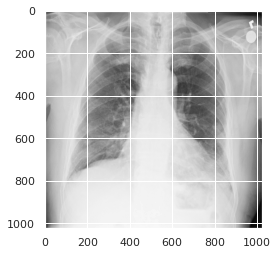

In [170]:
plt.imshow(dcm4.pixel_array,cmap='gray')

(array([2.4090e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5000e+01,
        5.1900e+02, 7.5000e+02, 6.9700e+02, 7.2200e+02, 8.0100e+02,
        8.5400e+02, 2.9900e+02, 9.6000e+01, 5.6000e+01, 5.9000e+01,
        6.9000e+01, 5.9000e+01, 7.1000e+01, 7.1000e+01, 7.3000e+01,
        8.3000e+01, 8.5000e+01, 9.7000e+01, 1.6800e+02, 1.5600e+02,
        1.3300e+02, 1.2700e+02, 1.2300e+02, 1.1600e+02, 1.1500e+02,
        1.0900e+02, 1.0700e+02, 1.0700e+02, 1.0500e+02, 1.0200e+02,
        1.2400e+02, 1.1000e+02, 1.0500e+02, 1.1900e+02, 1.3700e+02,
        1.3400e+02, 1.4600e+02, 1.7300e+02, 1.5000e+02, 1.5000e+02,
        1.5600e+02, 1.9100e+02, 1.9500e+02, 2.4200e+02, 2.9500e+02,
        2.9200e+02, 3.4600e+02, 4.0000e+02, 3.9900e+02, 4.3000e+02,
        4.9500e+02, 5.3700e+02, 5.6300e+02, 0.0000e+00, 7.1100e+02,
        6.9100e+02, 7.3300e+02, 7.4600e+02, 8.5700e+02, 9.7200e+02,
        1.0050e+03, 1.0940e+03, 1.1660e+03, 1.22

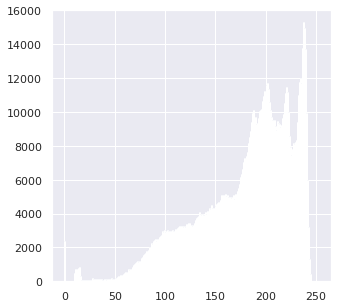

In [171]:
#plot a histogram of the image pixel intensity values
plt.figure(figsize=(5,5))
plt.hist(dcm4.pixel_array.ravel(), bins = 256)

In [172]:
#Find the mean and std dev intensity values of the image, and standerdize it
mean_intensity = np.mean(dcm4.pixel_array)
mean_intensity

180.0586576461792

In [173]:
std_intensity = np.std(dcm4.pixel_array)
std_intensity

47.89115072730743

In [174]:
new_img4 = dcm4.pixel_array.copy()
new_img4 = (new_img4 - mean_intensity)/std_intensity

(array([2.4090e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5000e+01,
        5.1900e+02, 7.5000e+02, 6.9700e+02, 7.2200e+02, 8.0100e+02,
        8.5400e+02, 2.9900e+02, 9.6000e+01, 5.6000e+01, 5.9000e+01,
        6.9000e+01, 5.9000e+01, 7.1000e+01, 7.1000e+01, 7.3000e+01,
        8.3000e+01, 8.5000e+01, 9.7000e+01, 1.6800e+02, 1.5600e+02,
        1.3300e+02, 1.2700e+02, 1.2300e+02, 1.1600e+02, 1.1500e+02,
        1.0900e+02, 1.0700e+02, 1.0700e+02, 1.0500e+02, 1.0200e+02,
        1.2400e+02, 1.1000e+02, 1.0500e+02, 1.1900e+02, 1.3700e+02,
        1.3400e+02, 1.4600e+02, 1.7300e+02, 1.5000e+02, 1.5000e+02,
        1.5600e+02, 1.9100e+02, 1.9500e+02, 2.4200e+02, 2.9500e+02,
        2.9200e+02, 3.4600e+02, 4.0000e+02, 3.9900e+02, 4.3000e+02,
        4.9500e+02, 5.3700e+02, 5.6300e+02, 0.0000e+00, 7.1100e+02,
        6.9100e+02, 7.3300e+02, 7.4600e+02, 8.5700e+02, 9.7200e+02,
        1.0050e+03, 1.0940e+03, 1.1660e+03, 1.22

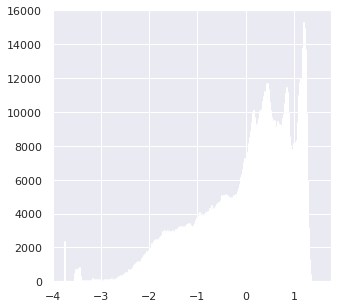

In [175]:
#Re-plot a histogram of the normalized intensity values
plt.figure(figsize=(5,5))
plt.hist(new_img4.ravel(), bins = 256)

In [176]:
#Now I will read in the 5th dicom file :
dcm5 = pydicom.dcmread('test5.dcm')

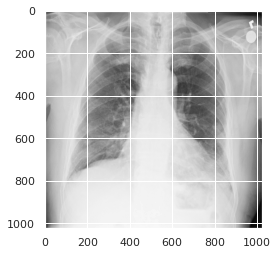

In [177]:
plt.imshow(dcm5.pixel_array,cmap='gray')

(array([2.4090e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5000e+01,
        5.1900e+02, 7.5000e+02, 6.9700e+02, 7.2200e+02, 8.0100e+02,
        8.5400e+02, 2.9900e+02, 9.6000e+01, 5.6000e+01, 5.9000e+01,
        6.9000e+01, 5.9000e+01, 7.1000e+01, 7.1000e+01, 7.3000e+01,
        8.3000e+01, 8.5000e+01, 9.7000e+01, 1.6800e+02, 1.5600e+02,
        1.3300e+02, 1.2700e+02, 1.2300e+02, 1.1600e+02, 1.1500e+02,
        1.0900e+02, 1.0700e+02, 1.0700e+02, 1.0500e+02, 1.0200e+02,
        1.2400e+02, 1.1000e+02, 1.0500e+02, 1.1900e+02, 1.3700e+02,
        1.3400e+02, 1.4600e+02, 1.7300e+02, 1.5000e+02, 1.5000e+02,
        1.5600e+02, 1.9100e+02, 1.9500e+02, 2.4200e+02, 2.9500e+02,
        2.9200e+02, 3.4600e+02, 4.0000e+02, 3.9900e+02, 4.3000e+02,
        4.9500e+02, 5.3700e+02, 5.6300e+02, 0.0000e+00, 7.1100e+02,
        6.9100e+02, 7.3300e+02, 7.4600e+02, 8.5700e+02, 9.7200e+02,
        1.0050e+03, 1.0940e+03, 1.1660e+03, 1.22

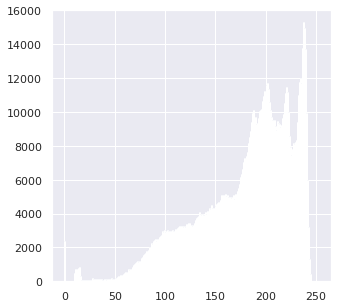

In [178]:
#plot a histogram of the image pixel intensity values
plt.figure(figsize=(5,5))
plt.hist(dcm5.pixel_array.ravel(), bins = 256)

In [179]:
#Find the mean and std dev intensity values of the image, and standerdize it
mean_intensity = np.mean(dcm5.pixel_array)
mean_intensity

180.0586576461792

In [180]:
std_intensity = np.std(dcm5.pixel_array)
std_intensity

47.89115072730743

In [181]:
new_img5 = dcm5.pixel_array.copy()
new_img5 = (new_img5 - mean_intensity)/std_intensity

(array([2.4090e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5000e+01,
        5.1900e+02, 7.5000e+02, 6.9700e+02, 7.2200e+02, 8.0100e+02,
        8.5400e+02, 2.9900e+02, 9.6000e+01, 5.6000e+01, 5.9000e+01,
        6.9000e+01, 5.9000e+01, 7.1000e+01, 7.1000e+01, 7.3000e+01,
        8.3000e+01, 8.5000e+01, 9.7000e+01, 1.6800e+02, 1.5600e+02,
        1.3300e+02, 1.2700e+02, 1.2300e+02, 1.1600e+02, 1.1500e+02,
        1.0900e+02, 1.0700e+02, 1.0700e+02, 1.0500e+02, 1.0200e+02,
        1.2400e+02, 1.1000e+02, 1.0500e+02, 1.1900e+02, 1.3700e+02,
        1.3400e+02, 1.4600e+02, 1.7300e+02, 1.5000e+02, 1.5000e+02,
        1.5600e+02, 1.9100e+02, 1.9500e+02, 2.4200e+02, 2.9500e+02,
        2.9200e+02, 3.4600e+02, 4.0000e+02, 3.9900e+02, 4.3000e+02,
        4.9500e+02, 5.3700e+02, 5.6300e+02, 0.0000e+00, 7.1100e+02,
        6.9100e+02, 7.3300e+02, 7.4600e+02, 8.5700e+02, 9.7200e+02,
        1.0050e+03, 1.0940e+03, 1.1660e+03, 1.22

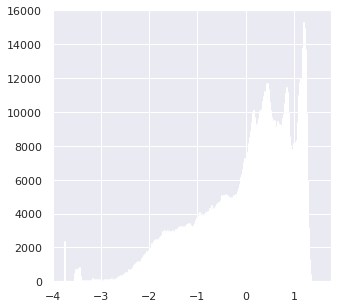

In [182]:
#Re-plot a histogram of the normalized intensity values
plt.figure(figsize=(5,5))
plt.hist(new_img5.ravel(), bins = 256)

In [183]:
#Now I will read in the 6th dicom file :
dcm6 = pydicom.dcmread('test6.dcm')

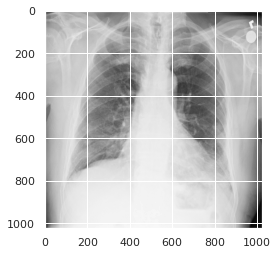

In [184]:
plt.imshow(dcm6.pixel_array,cmap='gray')

(array([2.4090e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5000e+01,
        5.1900e+02, 7.5000e+02, 6.9700e+02, 7.2200e+02, 8.0100e+02,
        8.5400e+02, 2.9900e+02, 9.6000e+01, 5.6000e+01, 5.9000e+01,
        6.9000e+01, 5.9000e+01, 7.1000e+01, 7.1000e+01, 7.3000e+01,
        8.3000e+01, 8.5000e+01, 9.7000e+01, 1.6800e+02, 1.5600e+02,
        1.3300e+02, 1.2700e+02, 1.2300e+02, 1.1600e+02, 1.1500e+02,
        1.0900e+02, 1.0700e+02, 1.0700e+02, 1.0500e+02, 1.0200e+02,
        1.2400e+02, 1.1000e+02, 1.0500e+02, 1.1900e+02, 1.3700e+02,
        1.3400e+02, 1.4600e+02, 1.7300e+02, 1.5000e+02, 1.5000e+02,
        1.5600e+02, 1.9100e+02, 1.9500e+02, 2.4200e+02, 2.9500e+02,
        2.9200e+02, 3.4600e+02, 4.0000e+02, 3.9900e+02, 4.3000e+02,
        4.9500e+02, 5.3700e+02, 5.6300e+02, 0.0000e+00, 7.1100e+02,
        6.9100e+02, 7.3300e+02, 7.4600e+02, 8.5700e+02, 9.7200e+02,
        1.0050e+03, 1.0940e+03, 1.1660e+03, 1.22

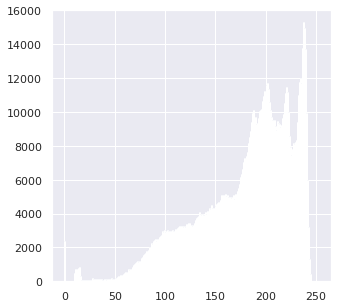

In [185]:
#plot a histogram of the image pixel intensity values
plt.figure(figsize=(5,5))
plt.hist(dcm6.pixel_array.ravel(), bins = 256)

In [186]:
#Find the mean and std dev intensity values of the image, and standerdize it
mean_intensity = np.mean(dcm6.pixel_array)
mean_intensity

180.0586576461792

In [187]:
std_intensity = np.std(dcm6.pixel_array)
std_intensity

47.89115072730743

In [188]:
new_img6 = dcm6.pixel_array.copy()
new_img6 = (new_img6 - mean_intensity)/std_intensity

(array([2.4090e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5000e+01,
        5.1900e+02, 7.5000e+02, 6.9700e+02, 7.2200e+02, 8.0100e+02,
        8.5400e+02, 2.9900e+02, 9.6000e+01, 5.6000e+01, 5.9000e+01,
        6.9000e+01, 5.9000e+01, 7.1000e+01, 7.1000e+01, 7.3000e+01,
        8.3000e+01, 8.5000e+01, 9.7000e+01, 1.6800e+02, 1.5600e+02,
        1.3300e+02, 1.2700e+02, 1.2300e+02, 1.1600e+02, 1.1500e+02,
        1.0900e+02, 1.0700e+02, 1.0700e+02, 1.0500e+02, 1.0200e+02,
        1.2400e+02, 1.1000e+02, 1.0500e+02, 1.1900e+02, 1.3700e+02,
        1.3400e+02, 1.4600e+02, 1.7300e+02, 1.5000e+02, 1.5000e+02,
        1.5600e+02, 1.9100e+02, 1.9500e+02, 2.4200e+02, 2.9500e+02,
        2.9200e+02, 3.4600e+02, 4.0000e+02, 3.9900e+02, 4.3000e+02,
        4.9500e+02, 5.3700e+02, 5.6300e+02, 0.0000e+00, 7.1100e+02,
        6.9100e+02, 7.3300e+02, 7.4600e+02, 8.5700e+02, 9.7200e+02,
        1.0050e+03, 1.0940e+03, 1.1660e+03, 1.22

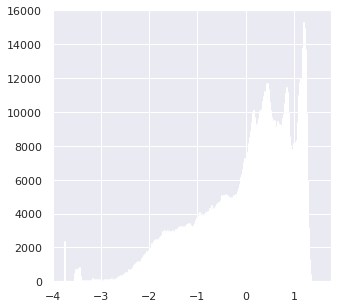

In [189]:
#Re-plot a histogram of the normalized intensity values
plt.figure(figsize=(5,5))
plt.hist(new_img6.ravel(), bins = 256)

In [190]:
import glob
mydicoms = glob.glob("*.dcm")

In [191]:
dcm1 = pydicom.dcmread(mydicoms[0])

In [192]:
dcm1

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'CT'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       

In [193]:
dcm1.StudyDescription


'No Finding'

In [194]:
dcm1.PatientID

'2'

In [195]:
dcm1.PatientSex

'M'

In [196]:
dcm1.PatientAge


'81'

In [197]:
dcm1.Rows

1024

In [198]:
dcm1.Columns

1024

In [199]:
dcm1.Modality

'CT'

In [200]:
#Now, let's create the dataframe that we want, and populate it in a loop with all of our DICOMS:
all_data = []

for i in mydicoms: 
    dcm = pydicom.dcmread(i)
    fields = [dcm.PatientID, int(dcm.PatientAge), dcm.PatientSex, dcm.Modality, dcm.StudyDescription,
             dcm.Rows, dcm.Columns]
    all_data.append(fields)


mydata = pd.DataFrame(all_data, 
                      columns = ['PatientID','PatientAge','PatientSex','Modality','Findings','Rows','Columns'])


mydata


,PatientID,PatientAge,PatientSex,Modality,Findings,Rows,Columns
0,2,81,M,CT,No Finding,1024,1024
1,2,81,M,DX,No Finding,1024,1024
2,2,81,M,DX,No Finding,1024,1024
3,1,58,M,DX,Cardiomegaly,1024,1024
4,61,77,M,DX,Effusion,1024,1024
5,2,81,M,DX,No Finding,1024,1024


My observation about all_xray_df dataset:
It has 1432 samples of pneumonia positive (1.2% of all samples) of which 1008 are unique patient IDs.
It has 60361 samples of pneumonia negative (53.8% of all samples) of which 24907 are unique patient IDs.
There is a big data imbalance which will need to be addressed when building a model. 
Aslo we will need to check for data leakage when spliting the dataset into training and validation because all dataset has 112,120 patient IDs from which 30,805 are unique IDs.
There are 14 diseases in this dataset + 'no finding' (healthy samples).
Infiltration and Edema are the most common comordidities of pneumonia.
There are a few more males than females in our dataset.
Age range is between 25 - 70 (pneumonia can affect young and old, but there are a few more patients 55-65 years old).
I have noticed that pneumonia has more spikes in the histogram compare to healthy x-ray.

My obesvation about sample_df dataset:
There are only 62 samples of pneumonia positive (1%).
There are 3044 samples of pneumonia negative (54%) or all dataset.
There are 5606 patient IDs and 4230 unique patient IDs.
I will build my model from all_xray_df dataset as it has more samples of pneumonia for training the model.
